6.8.21

Today, we'll try our first attempt at reading Pleiades data. 

6.9.21

So the big issue seems to be that we lack Zarr. However, we can probably still play around with the files that Hector has access too. Additionally, while llcreader would make life signifcantly easier as far as accessing data, it seems like Hector and Dimitris have most of what I needed stored in their respective nobackup files. So maybe let's put a pin in this

In [2]:
#accessing netcdf files from Hector's folders
import os, glob, sys
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import dask_ndfilters


In [3]:
# this is where Hector has surface current data stored
datadir = '/nobackup/htorresg/air_sea/ocean-atmos/NCFILES/geosgcm_surf_tides_4km/'
# 
Udir = datadir + 'U_0/' 
Vdir = datadir + 'V_0/'

In [4]:
U_ncfiles = os.listdir(Udir)
V_ncfiles = os.listdir(Vdir)

In [1]:
test_file = Udir + U_ncfiles[0]
ds = xr.open_dataset(test_file)

NameError: name 'Udir' is not defined

In [14]:
ds

<xarray.Dataset>
Dimensions:  (lat: 4501, lon: 9000, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    U        (time, lat, lon) float64 ...

In [6]:
test_file2 = Udir + U_ncfiles[-1]
ds_last = xr.open_dataset(test_file2)

In [7]:
ds_last

<xarray.Dataset>
Dimensions:  (lat: 4501, lon: 9000, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    U        (time, lat, lon) float64 ...

6.10.2021: I want to try merging Hector's data into one timeseries that can be visualized in a movie - - I think this is a decent facsimile of the first goal that Dimitris and I discussed.

In [25]:
Uc_mergefile = xr.open_dataset(test_file)
# above is the first .nc file in Hector's files 

# below, let's try a test merge
merge_test_file_name = Udir + U_ncfiles[1]
merge_test_file = xr.open_dataset(merge_test_file_name)
#confused by concatenate - why so many nan's?

6.10.2021 Merging is proving to be complicated - let me hit Xarray basics

In [27]:
ds.data_vars

Data variables:
    U        (time, lat, lon) float64 ...

In [36]:
ds.dims

Frozen(SortedKeysDict({'lat': 4501, 'lon': 9000, 'time': 1}))

In [34]:
ds.U[0] # select one variable and pick the first entry along the first axis (time)

<xarray.DataArray 'U' (lat: 4501, lon: 9000)>
[40509000 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [42]:
ds.U[0,2,3] # picks out specifics of the coordinates (2,3) label the 3 and 4 lat and lon respectively
# 0 index gets time

# It's probably smarter to concatenate with these U's instead of the full data set
# difference between a data array and a data set
# https://xarray-contrib.github.io/xarray-tutorial/online-tutorial-series/01_xarray_fundamentals.html

<xarray.DataArray 'U' ()>
array(nan)
Coordinates:
    lat      float64 -89.92
    lon      float64 -179.9

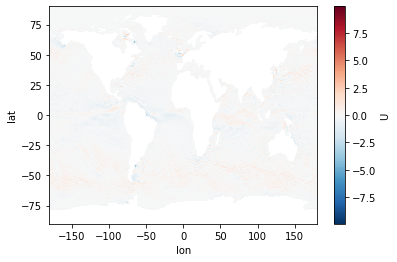

In [43]:
ds.U[0].plot()
# cool our first plot!!

In [49]:
ds.attrs # attributes -- stores meta data, probably something that Hector didn't feel the need to do

{}

In [50]:
#extract data arrays from data sets
ds["U"]

<xarray.DataArray 'U' (time: 1, lat: 4501, lon: 9000)>
[40509000 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time

In [51]:
ds.U.data #numpy array data - - the nans are mostly landmass

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00724101, 0.00724101, 0.00724101, ..., 0.00724101,
         0.00724101, 0.00724101],
        [0.00444164, 0.00444164, 0.00444164, ..., 0.00444164,
         0.00444164, 0.00444164],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])

In [52]:
ds
#see below in the data variables - - the nans are probably not an issue!

<xarray.Dataset>
Dimensions:  (lat: 4501, lon: 9000, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    U        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [70]:
# So let's try this again
# note that this is a fuck ton of things to compute - so we should definitely do some Dask Parallelization in a future
# iteration
Uc_mergefile = xr.open_dataset(test_file)
# above is the first .nc file in Hector's files 

# below, let's try a test merge
merge_test_file_name = Udir + U_ncfiles[1]
merge_test_file = xr.open_dataset(merge_test_file_name)
#confused by concatenate - why so many nan's?
merged_file = xr.concat([ds, merge_test_file], dim='time')

In [54]:
merged_file

<xarray.Dataset>
Dimensions:  (lat: 4501, lon: 9000, time: 2)
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    U        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [62]:
merged_file.U[0]

<xarray.DataArray 'U' (lat: 4501, lon: 9000)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.01471597, 0.01471597, 0.01471597, ..., 0.01471597, 0.01471597,
        0.01471597],
       [0.00660988, 0.00660988, 0.00660988, ..., 0.00660988, 0.00660988,
        0.00660988],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [ ]:
# So now let's do the fill dataset

Uc_mergefile = xr.open_dataset(test_file)
# a few notes - open_mfdataset seems to open multiple files as
# one dataset and this includes the "chunks" command which
# allows for dask paralellization 


# above is the first .nc file in Hector's files 

for i in range(1,len(U_ncfiles)):
    merge_file_name = Udir + U_ncfiles[i]
    merge_ds = xr.open_dataset(merge_file_name)
    Uc_mergefile = xr.concat([Uc_mergefile, merge_ds], dim='time')
    
    

In [68]:
# So how can we make a movie out of this??
# It's a lot of data - we're going to have to play with dask to get this to run fast
Uc_mergefile


<xarray.Dataset>
Dimensions:  (lat: 4501, lon: 9000, time: 55)
Coordinates:
  * lat      (lat) float64 -90.0 -89.96 -89.92 -89.88 ... 89.88 89.92 89.96 90.0
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    U        (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

For making movies - it'll probably be much smarter to go full dask parallelization and or cut the area you're graphing significantly. Maybe focus on Kuroshio area for the time being

6.11.2021: I'm going to attempt the above "merge" or at last data combination using Dask optimization tips and some better functions (open_mfdataset)

In [17]:
U_dir_files = [] #holds the full names of the files with the directory prefix

for i in range(0,len(U_ncfiles)):
    U_dir_files.append(Udir+U_ncfiles[i])
U_full_set = xr.open_mfdataset(U_dir_files, chunks={'latitude': 10, 'longitude': 10}, concat_dim='time',parallel=True, combine='nested')
#try this with a dask diagnostics check

In [ ]:
#with any luck the previous step actually worked correctly
#now, I'll save it to my folder in /nobackup
personal_dir = '/nobackup/amondal/NCData/FirstAttempt/'
file_name ='U0_full.nc'
U_full_set
U_full_set.to_netcdf(path=(personal_dir + filename))

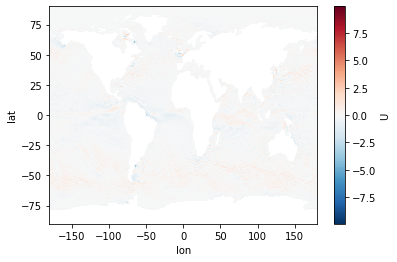

In [22]:
U_full_set.U[0].plot()

----------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------


6.9.21
Cool - so this was a first start at playing with Hector's data - it seems like at least U0 and presumably V0 have 917 files -- so that's in timesteps of some sort???. Probably MIT_xr_coas_....py has the time variables that will mention how time works for these - I can probably stack this in xarray and then do some analysis. Notes:

1. I'd want to chunk this to being analyzing things
2. It'd be good to try combining U0 and V0 to get surface speed.
3. I'm assuming these are in native_grid coordinates (the non poloar ones) but I should go back to the site and see how they refer to all these grid names
4. how to plot these - that's probably non-trivial

In [3]:
from xmitgcm import llcreader
# this is Ryan Abernathy's code from the article "Petabytes of Ocean Data ..."
model = llcreader.PleiadesLLC2160Model()
Abds = model.get_dataset(varnames=['Theta'], type='latlon', k_levels = [0])

In [2]:
Abds
#so this is a really convenient way to pull this not from Dimitris' diredctory. 

<xarray.Dataset>
Dimensions:  (face: 13, i: 8640, i_g: 8640, j: 6480, j_g: 6480, k: 1, k_l: 1, k_p1: 2, k_u: 1, time: 18679)
Coordinates: (12/47)
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 8633 8634 8635 8636 8637 8638 8639
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 8633 8634 8635 8636 8637 8638 8639
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 6473 6474 6475 6476 6477 6478 6479
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 6473 6474 6475 6476 6477 6478 6479
  * k        (k) int64 0
    ...       ...
    XG       (j_g, i_g) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    Theta    (time, k, j, i) float32 dask.array<chunksize=(1, 1, 6480, 2160), meta=np.ndarray>

In [8]:
# we can also do this with "model"
model

In [3]:
Abds.Theta.isel(k=0)

<xarray.DataArray 'Theta' (time: 18679, j: 6480, i: 8640)>
dask.array<getitem, shape=(18679, 6480, 8640), dtype=float32, chunksize=(1, 6480, 2160), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 8633 8634 8635 8636 8637 8638 8639
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 6473 6474 6475 6476 6477 6478 6479
    k        int64 0
  * time     (time) datetime64[ns] 2011-03-06 ... 2013-04-22T06:00:00
    CS       (j, i) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    ...       ...
    Z        >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(6480, 2160), meta=np.ndarray>
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
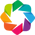

In [1]:
# How about visualization?
%matplotlib inline
import holoviews as hv
from holoviews.operation.datashader import regrid
hv.extension('bokeh')

In [4]:
dataset = hv.Dataset(Abds.Theta.isel(k=0).astype('f4'))
dataset

:Dataset   [i,j,time]   (Theta)

In [5]:
dataset = hv.Dataset(Abds.Theta.isel(k=0).astype('f4'))
hv_im = (dataset.to(hv.Image, ['i', 'j'], dynamic=True)
                .options(cmap='Magma', width=950, height=600, colorbar=True))

%output holomap='scrubber' fps=3
regrid(hv_im, precompute=True)

:DynamicMap   [time]
   :Image   [i,j]   (Theta)